In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        # 输出X的形状，（batch_size, num_steps, embed_size）
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状（num_steps, batch_size, num_hiddens）
        # state的形状（num_layers, batch_size, num_hiddens）
        return output, state

In [3]:
# 下面，我们实例化上述编码器的实现：我们使用一个两层门控循环单元编码器，其隐藏单元数为16。
# 给定一小批量的输入序列X（批量大小为4，时间步为7）。在完成所有时间步后，最后一层的隐状态的
# 输出是一个张量（output由编码器的循环层返回），其形状为（时间步数，批量大小，隐藏单元数）
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [4]:
# 由于这里使用的是门控循环单元，所以在最后一个时间步的多层隐状态形状是（隐藏层的数量，批量大小，隐藏单元的数量）。如果使用长短期记忆网络，state中还将包含记忆单元信息。
state.shape,state[0].shape, state[1].shape

(torch.Size([2, 4, 16]), torch.Size([4, 16]), torch.Size([4, 16]))

In [5]:
# 解码器
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 编码器输出+解码器输入
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens, num_layers, dropout=dropout)
        # 为了预测输出词元的概率分布
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        # 使用编码器最后一个时间步的隐状态来初始化解码器的隐状态
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：（batch_size, num_steps, embed_size）
        X = self.embedding(X).permute(1, 0, 2)
        # 广播context，使其具有与X相同的num_steps
        # state 形状是 （num_layers, batch_size, num_hiddens）
        context = state[-1].repeat(X.shape[0], 1, 1)  # 使其
        X_and_context = torch.cat((X, context), 2)
        # (num_steps, batch_size, num_hiddens+embed_size)
        output, state = self.rnn(X_and_context)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状：（batch_size, num_steps, vocab_size）
        # state 的形状：（num_layer, batch_size, num_hiddens）
        return output, state

In [6]:
# 下面我们与前面提到的编码器中相同的超参数来实例化解码器。如我们所见，解码器的输出形状为（批量大小，时间步数，词表大小），其中张量的最后一个维度存储预测的词元分布。
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

In [7]:
# 损失函数
# 在每个时间步，解码器预测了输出词元的概率分布。类似于语言模型，可以使用softmax来获得分布，并通过计算交叉熵损失函数来进行优化。特定的填充词元被添加到序列的末尾，因此不同长度的序列可以相同形状的小批量加载。但是，我们应该将填充词元的预测排除在损失函数的计算之外。
# 为此，我们可以使用下面的sequence_mask函数通过零值化屏蔽不相关的项，以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。例如，如果两个序列的有效长度（不包括填充词元）分别为1和2，则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [8]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)  # 获取序列最大长度
    # mask 序列的有效长度
    mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
    # [None, :] 左边扩充维度，[:, None] 右边扩充维度
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [9]:
import torch
test = torch.arange((3))
test[None, :], test[None, :].shape

(tensor([[0, 1, 2]]), torch.Size([1, 3]))

In [10]:
test[None, :]<torch.tensor([1, 2])[:, None]

tensor([[ True, False, False],
        [ True,  True, False]])

In [11]:
torch.tensor([1, 2])[:, None]

tensor([[1],
        [2]])

In [12]:
# 我们还可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [14]:
# 现在，我们可以扩展softmax交叉损失函数来遮蔽不相关的预测。最初，所有预测词元的掩码都设置为1。一旦给定了有效长度，与填充词元对应的
# 掩码将被设置为0。最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：（batch_size, num_steps, vocab_size）
    # label的形状：（batch_size, num_steps）
    # valid_len的形状：（batch_size, ）
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)  # 所有预测词元的掩码都设置为1
        weights = sequence_mask(weights, valid_len)  # 与填充词元对应的掩码将被设置为0
        self.reduction = 'none'  # 返回每个样本的损失，而不是所有样本损失的平均值
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)  # 将每个时间步的预测结果看成一个类别，从而使得nn.CrossEntropyLoss()函数能够计算交叉熵损失
        weighted_loss = (unweighted_loss * weights).mean(dim=1)  # 词元损失乘以掩码，过滤掉损失中填充词元产生的不相关预测
        return weighted_loss

In [15]:
# 我们可以创建三个相同序列来进行代码健全性检查，然后分别指定这些序列的有效长度为4，2，0，结果就是第一个序列的损失
# 为第二个序列的2倍，而第三个序列的损失应为0

In [16]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [17]:
# 训练
# 在下面的循环训练过程中，特定的序列开始词元（"<bos>"）和原始的输出序列（不包括序列结束词元"<eos>"）拼接在一起作为解码器的输入。
# 这被称为强制教学（teacher forcing），因为原始的输出序列（词元的标签）被送入解码器。或者，将来自上一个时间步的预测得到的词元得到的词元作为解码器的当前输入。

In [28]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
            # print(f'loss={metric[0]/ metric[1]:.3f}')
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss=0.024
loss 0.024, 10981.6 tokens/sec on cpu


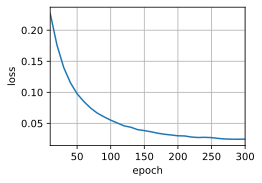

In [33]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, torch.device('cpu')

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [22]:
# 预测
# 为了采用一个接着一个词元的方式预测输出序列，每个解码器当前时间步的输入都来自于前一时间步的预测词元。与训练类似，序列开始词元
# （"<bos>"）在初始时间步被输入到解码器中。当输出序列的预测遇到结束词元（"<eos>"）时，预测就结束了。

In [38]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps, device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor([tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [39]:
# BLUE的代码实现如下：
def bleu(pred_seq, label_seq, k):
    """计算EBEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1-len_label/len_pred))
    for n in range(1, k+1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(pred_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join((pred_tokens[i: i + n]))] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i:i+n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [40]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai allons-y je pouvons-nous me entrez santé ça va <unk>, bleu 0.376
he's calm . => il lâche-toi au comment ., bleu 0.832
i'm home . => je réveillez-vous <unk> ! pouvons-nous nous je aboient <unk> !, bleu 0.577
